In [195]:
import json
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import re
from scipy.stats import mannwhitneyu, brunnermunzel

In [204]:
data = []
data1 = []
data2 = []
with open('data/cot-score-qwen.jsonl') as f:
    for line in f:
        data2.append(json.loads(line))
with open('data/cot-qwen.jsonl') as f:
    for line in f:
        data1.append(json.loads(line))
with open('data/NQ-baselinescore-qwen-plus.jsonl') as f:
    for line in f:
        data.append(json.loads(line))
    #for line in f:
    #    data.append(json.loads(line))
# Ainf - Asup
#data = [x for x in data if x['ainf'] == 1 or x['asup'] == 1]
# 用 (qid, system) 作为主键
dict1 = {(x['qid'], x['system']): x for x in data1}
dict2 = {(x['qid'], x['system']): x for x in data2}
dict3 = {(x['qid'], x['system']): x for x in data}

# 获取 data 的主键列表（顺序对齐）
target_keys = [(x['qid'], x['system']) for x in data]

# 按照 data 的顺序对齐
aligned_data1 = [dict1[k] for k in target_keys if k in dict1]
aligned_data2 = [dict2[k] for k in target_keys if k in dict2]
aligned_data = [x for x in data if (x['qid'], x['system']) in dict1 and (x['qid'], x['system']) in dict2]
print(len(aligned_data1), len(aligned_data2), len(aligned_data))
from sklearn.metrics import f1_score, precision_score, recall_score

y_true = [x['golden_judge'] for x in data]
y_pred = [x['system_judge'] for x in data]

prec = precision_score(y_true, y_pred)
rec = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
print(f'Precision: {prec:.3f}, Recall: {rec:.3f}, F1: {f1:.4f}')
print(len(y_true))

15045 15045 15045
Precision: 0.910, Recall: 0.957, F1: 0.9332
15045


In [197]:
def score_chain_info_assum(x):
    score = 100000
    if x['ainf'] == 0 and x['asup'] == 0:
        return -score
    if not x['chains']:
        return score
    for chain in x['chains']:
        steps = chain.split('\n')
        chain_score = 10 * len(steps)
        for s in steps:
            if '[[info]]' in s.lower():
                chain_score += 3
            if '[[assumption]]' in s.lower() or '(assumption)' in s.lower():
                chain_score += 5
        if chain_score < score:
            score = chain_score
        #score += chain_score
    score = -score
    return score


def score_info_assum(x):
    score = 100000
    if x['ainf'] == 0 and x['asup'] == 0:
        return -score
    if not x['chains']:
        return score
    for chain in x['chains']:
        steps = chain.split('\n')
        chain_score = 0
        for s in steps:
            if '[[info]]' in s.lower():
                chain_score += 3
            if '[[assumption]]' in s.lower() or '(assumption)' in s.lower():
                chain_score += 5
        if chain_score < score:
            score = chain_score
        #score += chain_score
    score = -score
    return score


def score_chain_only(x):
    score = 100000
    if x['ainf'] == 0 and x['asup'] == 0:
        return -score
    if not x['chains']:
        return score
    for chain in x['chains']:
        steps = chain.split('\n')
        chain_score = 10 * len(steps)
        if chain_score < score:
            score = chain_score
        #score += chain_score
    score = -score
    return score

def score_gpt35(x):
    if x['asup'] == 0 and x['ainf'] == 0:
        return -6
    if not x['scores']:
        return 0
    for score in x['scores']:
        # use regex to find integers in the string
        score = re.findall(r'\d+', score)
        if score:
            score = int(score[0])
            if score < 1 or score > 5:
                return -3
            return -score
    return -3

def score_baseline(x):
    if x['asup'] == 0 and x['ainf'] == 0:
        return -6
    if str(x['baseline_score']) == "-1":
        return 0
    text = x['baseline_score']
    for sc in range(1, 6):
        if str(sc) in text:
            return -sc
    else:
        return -3

def compute_f1(y_true, y_pred):
    from sklearn.metrics import precision_score, recall_score, f1_score
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    print(f'Precision: {prec:.3f}, Recall: {rec:.3f}, F1: {f1:.3f}')
    return prec, rec, f1

In [198]:

y_scores_1 = [score_chain_info_assum(x) for x in aligned_data1]
y_scores_2 = [score_chain_only(x) for x in aligned_data1]
y_scores_3 = [score_info_assum(x) for x in aligned_data1]
y_scores_4 = [score_gpt35(x) for x in aligned_data2]
y_scores_5 = [score_baseline(x) for x in aligned_data]

print(metrics.roc_auc_score(y_true, y_scores_1))
print(metrics.roc_auc_score(y_true, y_scores_2))
print(metrics.roc_auc_score(y_true, y_scores_3))
print(metrics.roc_auc_score(y_true, y_scores_4))
print(metrics.roc_auc_score(y_true, y_scores_5))


#disp = metrics.RocCurveDisplay.from_predictions(y_true, y_scores_1, name='CIA')
#disp = metrics.RocCurveDisplay.from_predictions(y_true, y_scores_2, name='C')
#disp = metrics.RocCurveDisplay.from_predictions(y_true, y_scores_3, name='gpt35')
#disp = metrics.RocCurveDisplay.from_predictions(y_true, y_scores_4, name='baseline')

0.9036507238998566
0.9004404682738448
0.9088000966531964
0.9101474964859929
0.8762897144005161


In [199]:
y_scores = y_scores_5
plot_df = []
for y_score, y_t in zip(y_scores, y_true):
    plot_df.append({'score': y_score, 'label': f'y_true={y_t}'})
plot_df = pd.DataFrame(plot_df)

<Axes: xlabel='score', ylabel='label'>

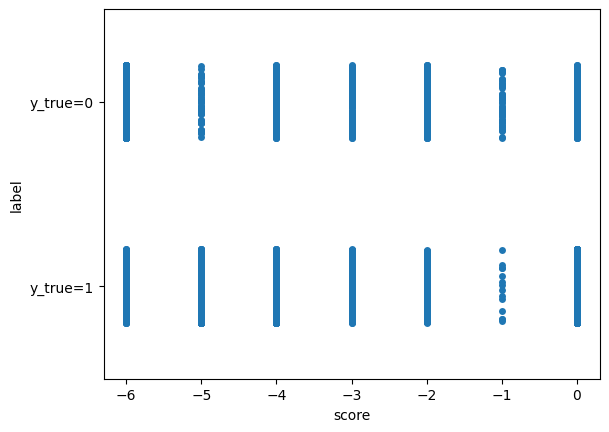

In [200]:
sns.stripplot(plot_df, x='score', y='label', jitter=0.2)

In [201]:
y_true_scores = plot_df[plot_df['label'] == 'y_true=1']['score']
y_false_scores = plot_df[plot_df['label'] == 'y_true=0']['score']
print(mannwhitneyu(y_true_scores, y_false_scores, alternative='greater'))
print(brunnermunzel(y_true_scores, y_false_scores, alternative='greater'))

MannwhitneyuResult(statistic=np.float64(38941698.0), pvalue=np.float64(0.0))
BrunnerMunzelResult(statistic=np.float64(-113.15339938119712), pvalue=np.float64(0.0))
